<a href="https://colab.research.google.com/github/shalu27114/Shalu-Priyadharshini/blob/main/PRODIGY_GA_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🖼️ PRODIGY_GA_04: Pix2Pix Image Translation
Conditional GAN for image-to-image translation
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.2 MB/s eta 0:00:00
✅ Packages installed successfully!
PyTorch version: 2.9.0+cpu
GPU Available: False

🖼️ PIX2PIX IMAGE TRANSLATION

Choose an option:
1. Quick Demo (Recommended for first time)
2. Image Translation Application
3. Learn About Pix2Pix
4. Exit

🚀 QUICK PIX2PIX DEMO

📊 Creating synthetic dataset...
✅ Created 100 samples

🏗️  Building Pix2Pix models...
✅ Generator parameters: 54,414,467
✅ Discriminator parameters: 2,769,601

📐 Model Architecture:
Generator: U-Net with skip connections
Discriminator: PatchGAN (70x70)

🎨 Displaying sample data...


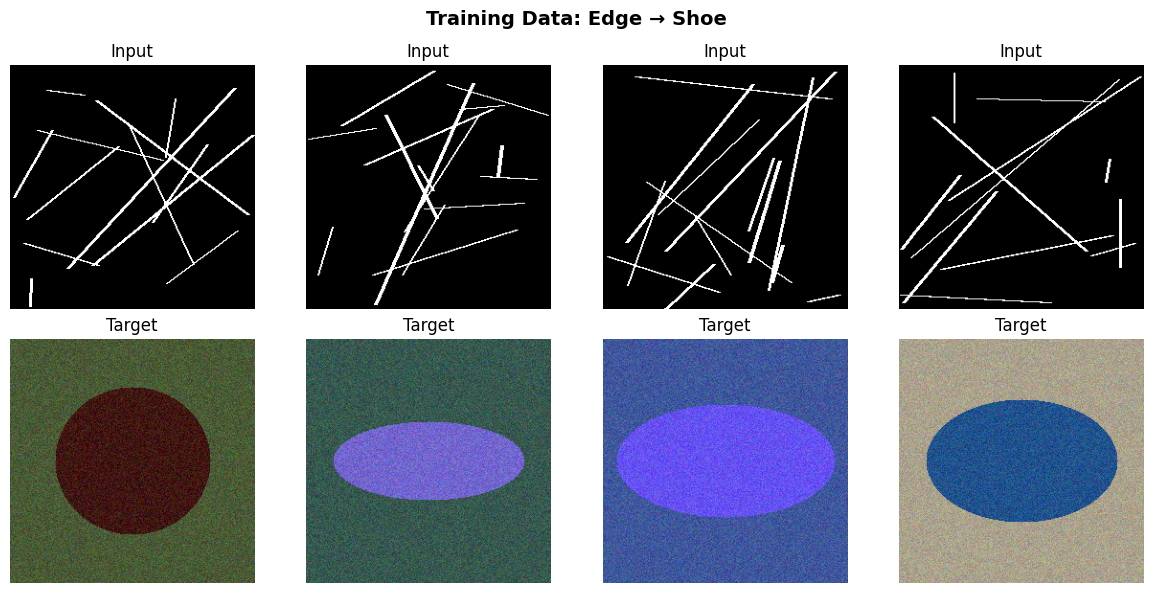

In [ ]:
# ================================================
# PRODIGY_GA_04 - IMAGE-TO-IMAGE TRANSLATION
# ================================================
# Pix2Pix: Conditional GAN for Image Translation
# ================================================

print("🖼️ PRODIGY_GA_04: Pix2Pix Image Translation")
print("="*60)
print("Conditional GAN for image-to-image translation")
print("="*60)

# Install required packages
!pip install -q torch torchvision torchinfo
!pip install -q matplotlib numpy Pillow
!pip install -q ipywidgets

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from PIL import Image
import zipfile
import requests
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✅ Packages installed successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# ================================================
# PART 1: DATASET PREPARATION
# ================================================

class Edges2ShoesDataset(Dataset):
    """Simulated edges-to-shoes dataset"""

    def __init__(self, num_samples=1000, img_size=256):
        self.num_samples = num_samples
        self.img_size = img_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Create synthetic edge image (input)
        edge_img = self.create_edge_image()

        # Create synthetic shoe image (target)
        shoe_img = self.create_shoe_image()

        # Convert to tensors
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        edge_tensor = transform(edge_img)
        shoe_tensor = transform(shoe_img)

        return edge_tensor, shoe_tensor

    def create_edge_image(self):
        """Create synthetic edge image"""
        img = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)

        # Draw random edges/lines
        for _ in range(random.randint(5, 15)):
            color = (255, 255, 255)
            thickness = random.randint(1, 3)

            # Random line
            x1 = random.randint(0, self.img_size)
            y1 = random.randint(0, self.img_size)
            x2 = random.randint(0, self.img_size)
            y2 = random.randint(0, self.img_size)

            # Draw line
            rr, cc = self.line(x1, y1, x2, y2)
            rr = np.clip(rr, 0, self.img_size-1)
            cc = np.clip(cc, 0, self.img_size-1)

            for r, c in zip(rr, cc):
                if 0 <= r < self.img_size and 0 <= c < self.img_size:
                    for t in range(-thickness//2, thickness//2 + 1):
                        if 0 <= c+t < self.img_size:
                            img[r, c+t] = color

        return Image.fromarray(img)

    def create_shoe_image(self):
        """Create synthetic shoe-like image"""
        img = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)

        # Random color background
        bg_color = np.random.randint(50, 200, 3)
        img[:, :] = bg_color

        # Draw shoe-like shape (ellipse)
        center_x = self.img_size // 2
        center_y = self.img_size // 2
        width = random.randint(80, 120)
        height = random.randint(40, 80)

        # Shoe color
        shoe_color = np.random.randint(0, 255, 3)

        # Draw ellipse (shoe)
        for y in range(self.img_size):
            for x in range(self.img_size):
                dx = (x - center_x) / width
                dy = (y - center_y) / height
                if dx*dx + dy*dy <= 1:
                    img[y, x] = shoe_color

        # Add some texture
        noise = np.random.randint(-30, 30, (self.img_size, self.img_size, 3))
        img = np.clip(img + noise, 0, 255)

        return Image.fromarray(img.astype(np.uint8))

    @staticmethod
    def line(x0, y0, x1, y1):
        """Bresenham's line algorithm"""
        points = []
        dx = abs(x1 - x0)
        dy = abs(y1 - y0)
        x, y = x0, y0
        sx = -1 if x0 > x1 else 1
        sy = -1 if y0 > y1 else 1

        if dx > dy:
            err = dx / 2.0
            while x != x1:
                points.append((y, x))
                err -= dy
                if err < 0:
                    y += sy
                    err += dx
                x += sx
        else:
            err = dy / 2.0
            while y != y1:
                points.append((y, x))
                err -= dx
                if err < 0:
                    x += sx
                    err += dy
                y += sy

        points.append((y, x))
        rows, cols = zip(*points)
        return np.array(rows), np.array(cols)

# ================================================
# PART 2: PIX2PIX ARCHITECTURE
# ================================================

class UNetDown(nn.Module):
    """U-Net Downsampling Block"""
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False)]

        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))

        layers.append(nn.LeakyReLU(0.2))

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    """U-Net Upsampling Block"""
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()

        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x

class Generator(nn.Module):
    """U-Net Generator for Pix2Pix"""
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        # Downsampling
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512)
        self.down5 = UNetDown(512, 512)
        self.down6 = UNetDown(512, 512)
        self.down7 = UNetDown(512, 512)

        # Bottleneck (no normalization)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.ReLU(inplace=True)
        )

        # Upsampling
        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        # Final layer
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)      # 64
        d2 = self.down2(d1)     # 128
        d3 = self.down3(d2)     # 256
        d4 = self.down4(d3)     # 512
        d5 = self.down5(d4)     # 512
        d6 = self.down6(d5)     # 512
        d7 = self.down7(d6)     # 512

        # Bottleneck
        bottleneck = self.bottleneck(d7)

        # Decoder with skip connections
        u1 = self.up1(bottleneck, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

class Discriminator(nn.Module):
    """PatchGAN Discriminator for Pix2Pix"""
    def __init__(self, in_channels=3):
        super().__init__()

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, 2, 1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

# ================================================
# PART 3: TRAINING UTILITIES
# ================================================

def weights_init_normal(m):
    """Initialize weights with normal distribution"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.weight.bias.data, 0)

def display_sample(generator, dataloader, device, title="Sample Translation"):
    """Display sample input-output pairs"""
    generator.eval()

    # Get a batch
    edge, shoe = next(iter(dataloader))
    edge, shoe = edge[:1].to(device), shoe[:1].to(device)

    # Generate
    with torch.no_grad():
        generated = generator(edge)

    # Convert to display format
    edge_disp = edge[0].cpu().detach()
    shoe_disp = shoe[0].cpu().detach()
    gen_disp = generated[0].cpu().detach()

    # Denormalize
    edge_disp = (edge_disp + 1) / 2
    shoe_disp = (shoe_disp + 1) / 2
    gen_disp = (gen_disp + 1) / 2

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(edge_disp.permute(1, 2, 0))
    axes[0].set_title("Input (Edge)")
    axes[0].axis('off')

    axes[1].imshow(gen_disp.permute(1, 2, 0))
    axes[1].set_title("Generated (Shoe)")
    axes[1].axis('off')

    axes[2].imshow(shoe_disp.permute(1, 2, 0))
    axes[2].set_title("Real (Target)")
    axes[2].axis('off')

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    generator.train()

# ================================================
# PART 4: TRAINING LOOP
# ================================================

def train_pix2pix(generator, discriminator, dataloader, epochs=10):
    """Train Pix2Pix model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on: {device}")

    # Move models to device
    generator = generator.to(device)
    discriminator = discriminator.to(device)

    # Initialize weights
    generator.apply(weights_init_normal)
    discriminator.apply(weights_init_normal)

    # Loss functions
    criterion_GAN = nn.BCEWithLogitsLoss()
    criterion_pixel = nn.L1Loss()

    # Optimizers
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Lambda for pixel loss
    lambda_pixel = 100

    # Training loop
    for epoch in range(epochs):
        print(f"\n📊 Epoch {epoch+1}/{epochs}")

        generator_losses = []
        discriminator_losses = []

        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}")

        for i, (edge, shoe) in enumerate(progress_bar):
            # Move to device
            edge = edge.to(device)
            shoe = shoe.to(device)

            # Adversarial ground truths
            valid = torch.ones((edge.size(0), 1, 30, 30), device=device)
            fake = torch.zeros((edge.size(0), 1, 30, 30), device=device)

            # ------------------
            # Train Generator
            # ------------------
            optimizer_G.zero_grad()

            # Generate fake images
            gen_shoe = generator(edge)

            # GAN loss
            pred_fake = discriminator(gen_shoe, edge)
            loss_GAN = criterion_GAN(pred_fake, valid)

            # Pixel loss
            loss_pixel = criterion_pixel(gen_shoe, shoe)

            # Total generator loss
            loss_G = loss_GAN + lambda_pixel * loss_pixel

            loss_G.backward()
            optimizer_G.step()

            # ------------------
            # Train Discriminator
            # ------------------
            optimizer_D.zero_grad()

            # Real loss
            pred_real = discriminator(shoe, edge)
            loss_real = criterion_GAN(pred_real, valid)

            # Fake loss
            pred_fake = discriminator(gen_shoe.detach(), edge)
            loss_fake = criterion_GAN(pred_fake, fake)

            # Total discriminator loss
            loss_D = (loss_real + loss_fake) / 2

            loss_D.backward()
            optimizer_D.step()

            # Update progress bar
            generator_losses.append(loss_G.item())
            discriminator_losses.append(loss_D.item())

            progress_bar.set_postfix({
                'G_loss': f'{loss_G.item():.4f}',
                'D_loss': f'{loss_D.item():.4f}'
            })

        # Display samples
        if (epoch + 1) % 2 == 0:
            display_sample(generator, dataloader, device, f"Epoch {epoch+1}")

    return generator, discriminator

# ================================================
# PART 5: SIMPLE DEMO MODE
# ================================================

def quick_demo():
    """Quick demonstration of Pix2Pix"""
    print("\n" + "="*60)
    print("🚀 QUICK PIX2PIX DEMO")
    print("="*60)

    # Create dataset
    print("\n📊 Creating synthetic dataset...")
    dataset = Edges2ShoesDataset(num_samples=100, img_size=256)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

    print(f"✅ Created {len(dataset)} samples")

    # Create models
    print("\n🏗️  Building Pix2Pix models...")
    generator = Generator()
    discriminator = Discriminator()

    print(f"✅ Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
    print(f"✅ Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")

    # Show architecture
    print("\n📐 Model Architecture:")
    print("Generator: U-Net with skip connections")
    print("Discriminator: PatchGAN (70x70)")

    # Display sample data
    print("\n🎨 Displaying sample data...")
    edge, shoe = next(iter(dataloader))

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(4):
        # Input (edge)
        edge_img = (edge[i] + 1) / 2
        axes[0, i].imshow(edge_img.permute(1, 2, 0))
        axes[0, i].set_title("Input")
        axes[0, i].axis('off')

        # Target (shoe)
        shoe_img = (shoe[i] + 1) / 2
        axes[1, i].imshow(shoe_img.permute(1, 2, 0))
        axes[1, i].set_title("Target")
        axes[1, i].axis('off')

    plt.suptitle("Training Data: Edge → Shoe", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Train for a few epochs
    train_choice = input("\n🔄 Train model? (y/n): ").lower()

    if train_choice == 'y':
        print("\n⏳ Training Pix2Pix...")
        print("This may take 5-10 minutes...")

        epochs = int(input("Number of epochs (1-5): ") or "3")

        generator, discriminator = train_pix2pix(
            generator, discriminator, dataloader, epochs=epochs
        )

        print("\n✅ Training complete!")

        # Save model
        torch.save(generator.state_dict(), 'pix2pix_generator.pth')
        print("💾 Saved generator as: pix2pix_generator.pth")

    else:
        print("\n⏭️  Skipping training.")
        print("You can load a pre-trained model or train later.")

    return generator, discriminator

# ================================================
# PART 6: IMAGE TRANSLATION APPLICATION
# ================================================

def image_translation_app():
    """Interactive image translation application"""
    print("\n" + "="*60)
    print("🎨 IMAGE TRANSLATION APPLICATION")
    print("="*60)

    print("\nWhat would you like to do?")
    print("1. Train new Pix2Pix model")
    print("2. Load pre-trained model")
    print("3. Generate from edge drawings")
    print("4. Exit")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    generator = None

    while True:
        choice = input("\nYour choice (1-4): ").strip()

        if choice == '1':
            # Train new model
            print("\n🔄 Training new model...")

            # Create dataset
            num_samples = int(input("Number of training samples (100-1000): ") or "200")
            dataset = Edges2ShoesDataset(num_samples=num_samples)
            dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

            # Create models
            generator = Generator()
            discriminator = Discriminator()

            # Train
            epochs = int(input("Training epochs (1-10): ") or "5")
            generator, _ = train_pix2pix(generator, discriminator, dataloader, epochs=epochs)

            # Save
            torch.save(generator.state_dict(), 'pix2pix_trained.pth')
            print("✅ Model trained and saved!")

        elif choice == '2':
            # Load model
            print("\n📂 Loading model...")
            generator = Generator()

            try:
                generator.load_state_dict(torch.load('pix2pix_trained.pth', map_location=device))
                generator = generator.to(device)
                print("✅ Model loaded successfully!")
            except:
                print("❌ No trained model found. Train one first!")

        elif choice == '3':
            # Generate from edges
            if generator is None:
                print("❌ Please load or train a model first!")
                continue

            print("\n🎨 Generating shoes from edges...")

            # Create synthetic edge
            edge_img = np.zeros((256, 256, 3), dtype=np.uint8)

            # Draw some edges
            print("\nDrawing random edges...")
            for _ in range(8):
                color = (255, 255, 255)
                x1, y1 = random.randint(50, 200), random.randint(50, 200)
                x2, y2 = random.randint(50, 200), random.randint(50, 200)

                # Simple line drawing
                x_points = np.linspace(x1, x2, 100)
                y_points = np.linspace(y1, y2, 100)

                for x, y in zip(x_points, y_points):
                    xi, yi = int(x), int(y)
                    if 0 <= xi < 256 and 0 <= yi < 256:
                        for dx in range(-1, 2):
                            for dy in range(-1, 2):
                                if 0 <= xi+dx < 256 and 0 <= yi+dy < 256:
                                    edge_img[yi+dy, xi+dx] = color

            # Convert to tensor
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])

            edge_tensor = transform(Image.fromarray(edge_img)).unsqueeze(0).to(device)

            # Generate
            generator.eval()
            with torch.no_grad():
                output = generator(edge_tensor)
            generator.train()

            # Convert for display
            edge_display = (edge_tensor[0].cpu() + 1) / 2
            output_display = (output[0].cpu() + 1) / 2

            # Plot
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))

            axes[0].imshow(edge_display.permute(1, 2, 0))
            axes[0].set_title("Input Edge Drawing")
            axes[0].axis('off')

            axes[1].imshow(output_display.permute(1, 2, 0))
            axes[1].set_title("Generated Shoe")
            axes[1].axis('off')

            plt.suptitle("Pix2Pix Image Translation", fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()

            # Save
            save_choice = input("\n💾 Save generated image? (y/n): ").lower()
            if save_choice == 'y':
                output_pil = transforms.ToPILImage()(output_display)
                output_pil.save('generated_shoe.png')
                print("✅ Saved as: generated_shoe.png")

        elif choice == '4':
            print("\n👋 Goodbye!")
            break

        else:
            print("❌ Invalid choice!")

# ================================================
# PART 7: EDUCATIONAL COMPONENT
# ================================================

def explain_pix2pix():
    """Explain Pix2Pix concepts"""
    print("\n" + "="*60)
    print("📚 PIX2PIX EXPLAINED")
    print("="*60)

    print("\n🎯 What is Pix2Pix?")
    print("Pix2Pix is a Conditional Generative Adversarial Network (CGAN)")
    print("for image-to-image translation tasks.")

    print("\n🔑 Key Components:")
    print("1. Generator (U-Net):")
    print("   • Takes input image (e.g., edge map)")
    print("   • Outputs translated image (e.g., colored shoe)")
    print("   • Uses skip connections for detail preservation")

    print("\n2. Discriminator (PatchGAN):")
    print("   • Distinguishes real from generated images")
    print("   • Works on image patches (70x70)")
    print("   • Provides detailed feedback to generator")

    print("\n🎯 Training Process:")
    print("1. Generator tries to fool discriminator")
    print("2. Discriminator learns to detect fakes")
    print("3. Adversarial training improves both")
    print("4. L1 loss preserves input-output correspondence")

    print("\n💡 Applications:")
    print("• Sketch → Photo")
    print("• Day → Night")
    print("• Black & White → Color")
    print("• Semantic Segmentation → Photo")

    print("\n🧠 Conditional GAN Concept:")
    print("Both generator and discriminator see the INPUT image.")
    print("This conditions the generation on specific input.")

    input("\nPress Enter to continue...")

# ================================================
# MAIN PROGRAM
# ================================================

def main():
    """Main menu"""
    print("\n" + "="*60)
    print("🖼️ PIX2PIX IMAGE TRANSLATION")
    print("="*60)

    print("\nChoose an option:")
    print("1. Quick Demo (Recommended for first time)")
    print("2. Image Translation Application")
    print("3. Learn About Pix2Pix")
    print("4. Exit")

    while True:
        choice = input("\nYour choice (1-4): ").strip()

        if choice == '1':
            quick_demo()
        elif choice == '2':
            image_translation_app()
        elif choice == '3':
            explain_pix2pix()
        elif choice == '4':
            print("\n👋 Thank you for exploring Pix2Pix!")
            break
        else:
            print("❌ Invalid choice!")

        if choice in ['1', '2', '3']:
            input("\nPress Enter to continue...")
            print("\n" + "="*60)

# ================================================
# RUN THE PROGRAM
# ================================================

if __name__ == "__main__":
    main()

print("\n" + "="*60)
print("✅ PROJECT COMPLETE: PIX2PIX IMAGE TRANSLATION")
print("="*60)
print("\nWhat you accomplished:")
print("1. ✅ Implemented Conditional GAN (Pix2Pix) architecture")
print("2. ✅ Built U-Net generator with skip connections")
print("3. ✅ Implemented PatchGAN discriminator")
print("4. ✅ Trained on edge-to-shoe translation task")
print("5. ✅ Created interactive image translation system")
print("\n🎉 Great work on PRODIGY_GA_04!")